In [213]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr


In [290]:
density_array = xr.DataArray(np.zeros((20,20)))
a = np.zeros((20))
a[0] = a[0] + 1
a[2] = a[2] + 1
a[4] = a[4] + 1
a[6] = a[6] + 1
a[8] = a[8] + 1
a[10] = a[10] + 1
a[12] = a[12] + 1
a[14] = a[14] + 1
a[16] = a[16] + 1
a[18] = a[18] + 1

for i in range(len(a)):
    a[i] = a[i] + i

d_array = np.arange(0,200,10) + 5 
cell_thickness_array = np.ones(d_array.shape)*10

depth = xr.DataArray(np.expand_dims(d_array,axis=0)).rename({"dim_1":"depth"}).squeeze("dim_0")
cell_thickness = xr.DataArray(np.expand_dims(cell_thickness_array,axis=0)).rename({"dim_1":"depth"}).squeeze("dim_0")

for i in range(len(depth)):
    depth[i] = depth[i] + i
    
velocity_array = xr.DataArray(np.ones((20,20))).assign_coords(dim_0 = d_array).rename({"dim_0":"depth","dim_1":"lat"})

for i in range(0,20):
    density_array[i] = density_array[i] + i*5 + a

density_array = density_array.assign_coords(dim_0 = d_array).rename({"dim_0":"depth","dim_1":"lat"})

density_level = 90


In [291]:
print(depth)

<xarray.DataArray (depth: 20)>
array([  5,  16,  27,  38,  49,  60,  71,  82,  93, 104, 115, 126, 137, 148,
       159, 170, 181, 192, 203, 214])
Dimensions without coordinates: depth


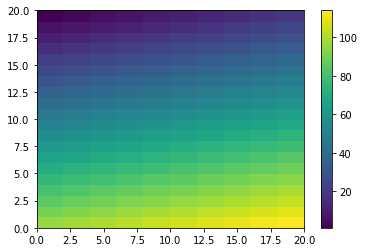

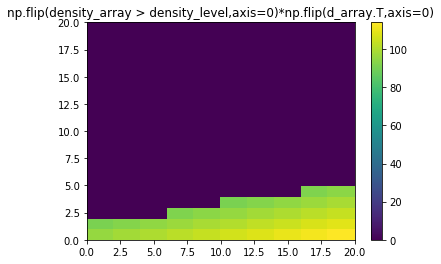

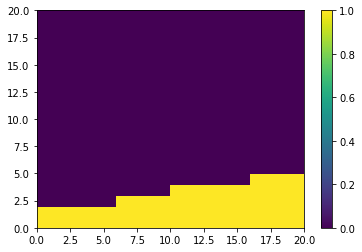

In [292]:
plt.pcolor(np.flip(density_array,axis=0))
plt.colorbar()
plt.show()
plt.close()

plt.pcolor(np.flip(density_array > density_level,axis=0)*np.flip(density_array,axis=0))
plt.title("np.flip(density_array > density_level,axis=0)*np.flip(d_array.T,axis=0)")
plt.colorbar()
plt.show()
plt.close()

plt.pcolor(np.flip(density_array > density_level,axis=0))
plt.colorbar()
plt.show()
plt.close()

In [301]:
density_stencil = density_array > density_level
# set end-appended value equal to 1 for subtraction step..
density_stencil_above = np.concatenate((density_stencil[1:,:],density_stencil[-1:,:]),axis=0)
# set top-appended value equal to zero..
density_stencil_below = np.concatenate((density_stencil[:1,:]*0,density_stencil[:-1,:]),axis=0)
density_stencil_above_top_level = density_stencil_above - density_stencil
density_stencil_top_level = density_stencil - density_stencil_below


depth_above_top_level_1 = (density_stencil_above_top_level*depth).sum(dim="depth")
depth_above_top_level = depth_above_top_level_1.where(depth_above_top_level_1 > 0,other=np.nan)

depth_top_level_1 = (density_stencil_top_level*depth).sum(dim="depth")
depth_top_level = depth_top_level_1.where(depth_top_level_1 > 0,other=np.nan)

density_above_top_level = (density_stencil_above_top_level*density_array).sum(dim="depth")
density_top_level = (density_stencil_top_level*density_array).sum(dim="depth")

velocity_above_top_level = (density_stencil_above_top_level*velocity_array/cell_thickness).sum(dim="depth")
velocity_top_level = (density_stencil_top_level*velocity_array/cell_thickness).sum(dim="depth")

density_slope = (depth_above_top_level - depth_top_level)/(density_above_top_level - density_top_level)
velocity_slope = (velocity_above_top_level - velocity_top_level)/(depth_above_top_level - depth_top_level)

h_array = (density_level - density_top_level)*density_slope

transport_integral_1 = velocity_slope*((depth.max() - depth_top_level - h_array)**2) + velocity_top_level*(-h_array)
transport_integral_1 = transport_integral_1.fillna(0)
transport_integral_2 = velocity_slope*((depth.max() - depth_top_level)**2)
transport_integral_2 = transport_integral_2.fillna(0)



transport_level = transport_integral_1 - transport_integral_2




<xarray.DataArray (lat: 20)>
array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.])
Dimensions without coordinates: lat
<xarray.DataArray (depth: 20, lat: 20)>
array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ..., 
       [192, 192, 192, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])
Coordinates:
  * depth    (depth) int64 5 16 27 38 49 60 71 ... 148 159 170 181 192 203 214
Dimensions without coordinates: lat


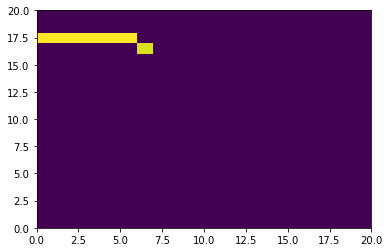

In [308]:
a = (transport_level*0+1)
a[7:] = 0
print(a)
print(depth*density_stencil_above_top_level)
plt.pcolor(depth*density_stencil_above_top_level*a)
#print(density_top_level)
#print(density_slope)
#print(depth_above_top_level)
#print(depth_top_level)
#print(density_above_top_level)
#print(density_top_level)

In [259]:
print(density_stencil.isel(depth=slice(1,20)))


<xarray.DataArray (depth: 19, lat: 20)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)
Coordinates:
  * depth    (depth) int64 16 27 38 49 60 71 82 ... 148 159 170 181 192 203 214
Dimensions without coordinates: lat


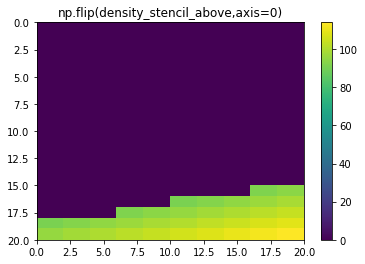

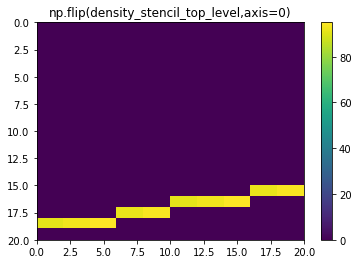

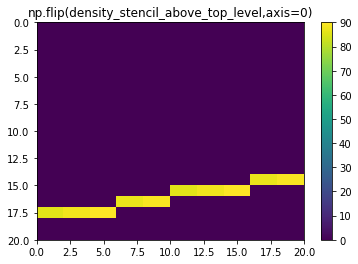

In [283]:
plt.pcolor(density_stencil*density_array)
plt.title("np.flip(density_stencil_above,axis=0)")
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()
plt.close()

plt.pcolor(density_stencil_top_level*density_array)
plt.title("np.flip(density_stencil_top_level,axis=0)")
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()
plt.close()

plt.pcolor(density_stencil_above_top_level*density_array)
plt.title("np.flip(density_stencil_above_top_level,axis=0)")
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()
plt.close()

In [261]:
print(transport_level)

<xarray.DataArray (lat: 20)>
array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.])
Dimensions without coordinates: lat


In [253]:
data = np.arange(0,20)*0+1
data[0] = 0
depth = np.arange(0,20)

a = xr.DataArray(data,coords=[depth],dims=["depth"])

In [254]:
print(a)

<xarray.DataArray (depth: 20)>
array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Coordinates:
  * depth    (depth) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19


In [255]:
b = xr.concat((a.isel(depth=0)*0,a.isel(depth=slice(0,19))),dim="depth").assign_coords(depth=depth)


In [256]:
print(a)
print(b)

<xarray.DataArray (depth: 20)>
array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Coordinates:
  * depth    (depth) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
<xarray.DataArray (depth: 20)>
array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Coordinates:
  * depth    (depth) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19


In [236]:
print(a-b)

<xarray.DataArray (depth: 20)>
array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
  * depth    (depth) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19


<xarray.DataArray (dim_0: 20)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])
Dimensions without coordinates: dim_0
